In [2]:
import os
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

from owl_vit import configs
from owl_vit import models
from owl_vit import inference

import tensorflow as tf

config = configs.owl_v2_clip_b16.get_config()
module = models.TextZeroShotDetectionModule(
    body_configs=config.model.body,
    normalize=config.model.normalize,
    box_bias=config.model.box_bias)
variables = module.load_variables(config.init_from.checkpoint_path)

model = inference.Model(config, module, variables)
model.warm_up()


100%|█████████████████████████████████████| 1.29M/1.29M [00:00<00:00, 45.2MiB/s]
I0000 00:00:1723376554.187104   32839 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-11 20:42:34.203927: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
from owl_vit.utils import box_utils
from owl_vit.utils.nms import nms

def find_text(comma_separated_queries: str, model: inference.Model, image: np.ndarray, threshold=0.1):
    queries = [q.strip() for q in comma_separated_queries.split(',')]
    queries = tuple(q for q in queries if q)
    num_queries = len(queries)

    if not num_queries:
        return None

    # Compute box display alphas based on prediction scores:
    _, _, boxes = model.embed_image(image)
    query_embeddings = model.embed_text_queries(queries)
    top_query_ind, scores = model.get_scores(image, query_embeddings, num_queries)

    indices = np.argwhere(scores > threshold).reshape(-1)

    factor = max(*image.shape[:2])
    boxes = np.array(box_utils.box_cxcywh_to_xyxy(boxes[indices])) * factor
    scores = np.array(scores[indices])

    indices = nms(boxes, scores, 0.5)
    
    return boxes[indices], scores[indices]

[[325.76715  67.1081  423.06546 326.1067 ]
 [ 80.33586  71.61569 474.8997  389.89368]
 [169.86255  16.80185 408.92984 302.71432]] [0.89691097 0.5902372  0.5334233 ]


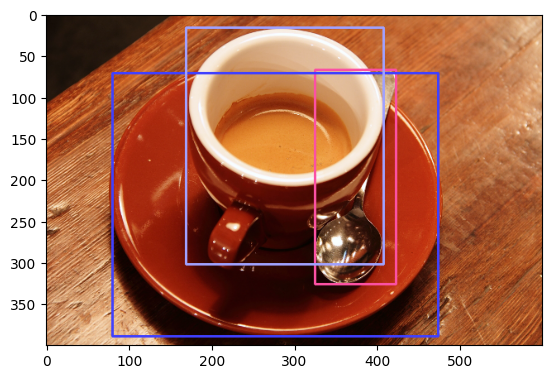

In [4]:
import supervision as sv

image = np.array(Image.open('./images/coffee.png').convert('RGB'))
height, width = image.shape[:2]

boxes, scores = find_text('coffee mug, spoon, plate', model, image, 0.3)

print(boxes, scores)

detections = sv.Detections(xyxy=boxes)
annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
frame = image.copy()
frame = annotator.annotate(frame, detections=detections)

fig, ax = plt.subplots(1, 1)
ax.imshow(frame)
plt.show()

In [5]:
def find_image(
    model: inference.Model,
    target_image: np.ndarray,
    query_image: np.ndarray,
    query_box=None,
    threshold=0.1
):
    h, w = query_image.shape[:2]
    
    if query_box is None:
        query_image = np.pad(query_image, ((h, h), (w, w), (0, 0)), constant_values=0.5)
        scale = 3 * max(h, w)
        y1, x1, y2, x2 = np.array([h, w, 2 * h, 2 * w]) / scale
        query_box = (y1, x1, y2, x2)
        # scale = max(h, w)
        # query_box = (0, 0, h / scale, w / scale)

    else:
        scale = max(h, w)
        x1, y1, x2, y2 = np.array(query_box) / scale
        query_box = (y1, x1, y2, x2)

    query_embedding, best_box_ind = model.embed_image_query(query_image, query_box)
    _, _, boxes = model.embed_image(target_image)

    top_query_ind, scores = model.get_scores(target_image, query_embedding[None, ...], num_queries=1)
  
    indices = np.argwhere(scores > threshold).reshape(-1)

    factor = max(*image.shape[:2])
    boxes = np.array(box_utils.box_cxcywh_to_xyxy(boxes[indices])) * factor
    scores = np.array(scores[indices])

    indices = nms(boxes, scores, 0.3)

    return boxes[indices], scores[indices]

In [6]:
import requests
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')
image = np.array(image)

# query_url = "http://images.cocodataset.org/val2017/000000058111.jpg"
# prompt = Image.open(requests.get(query_url, stream=True).raw).convert('RGB')
# prompt = np.array(prompt)

prompt = Image.open('./images/remocon.jpg').convert('RGB')
prompt = np.array(prompt)

[[ 40.35437  73.2652  175.48322 117.49938]
 [334.93115  77.32764 366.91037 187.1323 ]] [0.9998305  0.99936265]


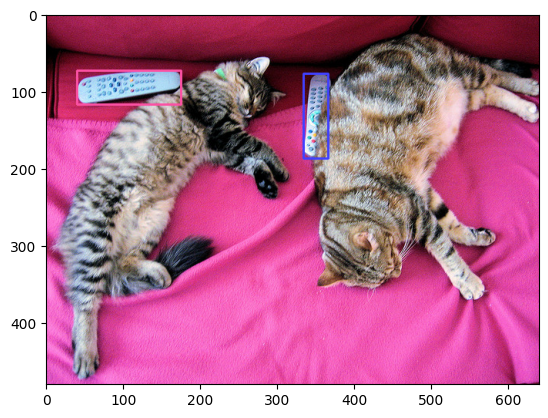

In [7]:
boxes, scores = find_image(model, image, prompt, threshold=0.9)

print(boxes, scores)

detections = sv.Detections(xyxy=boxes)
annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)

frame = annotator.annotate(image.copy(), detections=detections)

fig, ax = plt.subplots(1, 1)
ax.imshow(frame)
plt.show()
